## Bayes module

### Variational inference

Given a score $S$, a parametric family of distributions $(\nu_{\theta})_{\theta \in \Theta}$ and a prior distribution $\pi$, we consider the variational problem

$$\hat{\theta} = \arg\inf \nu_{\theta}[S] + \lambda * KL(\nu_{\theta}, \pi).$$

The function variational_inference is designed to tackle such problems in the setting where $\pi =  \nu_{\theta_0}$. This is in order to benefit from potential closed form expressions when computing the Kullback--Leibler divergence and its derivative.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from aduq.bayes import iter_prior, variational_inference, iter_prior_vi
from aduq.proba import GaussianMap, TensorizedGaussianMap

# For plotting purposes
from math import pi
angles = np.linspace(0, 2 * pi, 1000)
circle = np.array([np.cos(angles), np.sin(angles)])

def half_cov(cov):
    vals, vects = np.linalg.eigh(cov)
    return (np.sqrt(vals) * vects) @ vects.T

def repr_gauss(mean, cov, rad =1.0):
    loc_circle = circle.copy()
    return mean + rad * (half_cov(cov) @ loc_circle).T

# Toy score function
def score(x):
    return (x @ np.array([0, 1]) - 1) ** 2 + 10 * (x @ np.array([1, -1])) **2

We need to define the space of probability distributions on which we wish to optimize. Here we consider a score defined on a two dimensional space, and therefore use gaussian distributions on $\mathbb{R}^2$. The prior will be the standard distribution

It is normal behavior that the optimisation procedure raises some ProbaBadGrad warnings.These indicate that a problematic gradient estimation was rejected as it damaged significantly the score. No need to worry about those.

In [3]:
gauss_map = GaussianMap(2)

# We define the prior as the reference gaussian distribution, i.e. N(0,Id)
prior_param = gauss_map.ref_param

# To solve the variational inference problem, we use the variational_inference function.
opt_res = variational_inference(
    score, gauss_map,
    prior_param=prior_param,
    temperature=.1, # the lambda term in the variational inference problem
    per_step=160,
    VI_method='corr_weights',
    gen_decay=np.log(1.1),
    k = 160 * 20,
    parallel=False,
    vectorized=True,
    print_rec=100, chain_length=501,
    refuse_conf=.95,
    momentum=.95, eta=0.6, silent=False)

# It is normal behavior that the optimisation procedure raises some ProbaBadGrad warnings.
# These indicate that a problematic gradient estimation was rejected as it damaged significantly
# the score. No need to worry about those.

# We can access the parameter describing the posterior through the opti_param attribute
post_param = opt_res.opti_param

Score at step 0: 22.29547763474304 (KL: 0.0, score:22.29547763474304)


/Users/apicard/Documents/Suez/Git/ADUncertaintyQuantification/aduq/bayes/variational_inference.py:696: ProbBadGrad: 
            Harmful step removed.
            (Previous score: 17.834066384926942, new_score: 61.15511355096503, UQ: 7.379019273821632))
  warnings.warn(
/Users/apicard/Documents/Suez/Git/ADUncertaintyQuantification/aduq/bayes/variational_inference.py:696: ProbBadGrad: 
            Harmful step removed.
            (Previous score: 2.249641908192324, new_score: 9.916660548550151, UQ: 1.0725165382757025))
  warnings.warn(
/Users/apicard/Documents/Suez/Git/ADUncertaintyQuantification/aduq/bayes/variational_inference.py:696: ProbBadGrad: 
            Harmful step removed.
            (Previous score: 1.8115300920173592, new_score: 4.838244225250629, UQ: 0.4535486473176891))
  warnings.warn(
/Users/apicard/Documents/Suez/Git/ADUncertaintyQuantification/aduq/bayes/variational_inference.py:696: ProbBadGrad: 
            Harmful step removed.
            (Previous score: 1.6830

Score at step 100: 0.5616217428995584 (KL: 3.5767188791195688, score:0.20394985498760146)
Score at step 200: 0.5299248761456437 (KL: 3.9397534903346565, score:0.13594952711217795)
Score at step 300: 0.5101427439606201 (KL: 4.068933237973991, score:0.10324942016322092)
Score at step 400: 0.5104206150619949 (KL: 3.986125906761672, score:0.1118080243858277)
Score at step 500: 0.5094816368697138 (KL: 4.0826832338162315, score:0.10121331348809062)


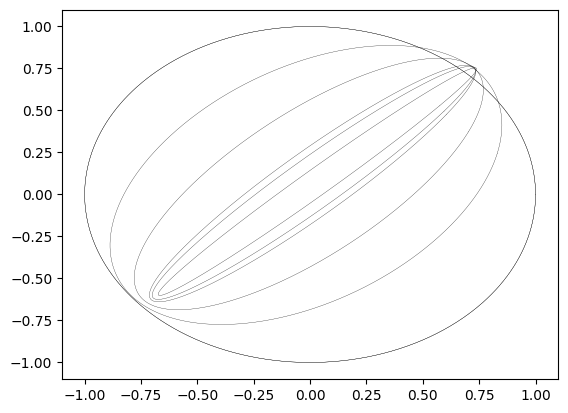

In [4]:
# The optimisation start by modification of the covariance 

for i, param in enumerate(opt_res.hist_param[:13:2]):
    if i % 1 == 0:
        distr = gauss_map(param)
        distr_repr = repr_gauss(distr.means, distr.cov)
        plt.plot(distr_repr[:,0], distr_repr[:,1], color='black', linewidth=0.2)

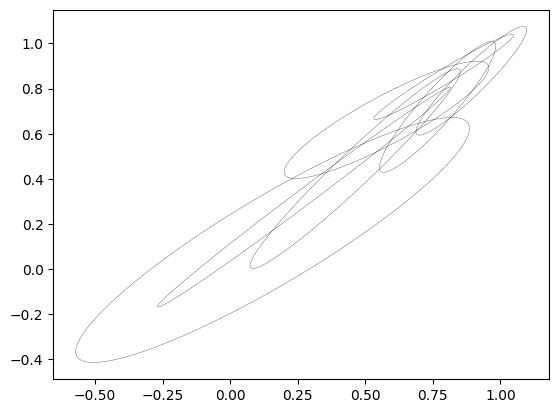

In [5]:
# The distribution then shifts towards the correct mean value
for i, param in enumerate(opt_res.hist_param[20:160:20]):
    if i % 1 == 0:
        distr = gauss_map(param)
        distr_repr = repr_gauss(distr.means, distr.cov)
        plt.plot(distr_repr[:,0], distr_repr[:,1], color='black', linewidth=0.2)

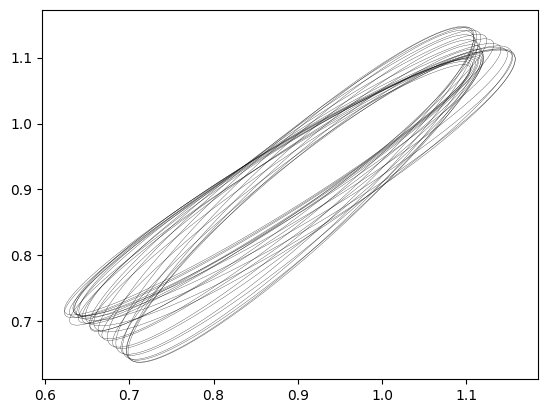

In [6]:
# The last steps then adjust the distribution
for i, param in enumerate(opt_res.hist_param[150:200:2]):
    if i % 1 == 0:
        distr = gauss_map(param)
        distr_repr = repr_gauss(distr.means, distr.cov)
        plt.plot(distr_repr[:,0], distr_repr[:,1], color='black', linewidth=0.2)

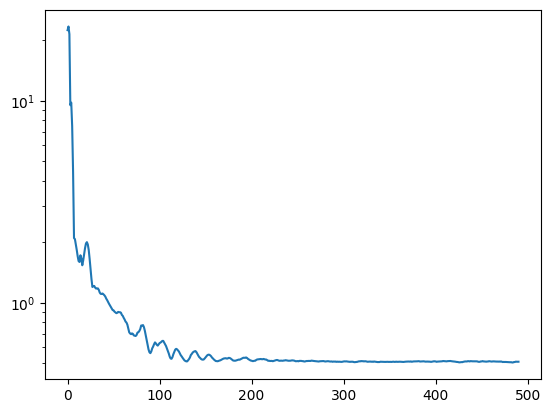

In [7]:
# The evolution of the VI score can also be tracked:
plt.plot(opt_res.hist_score)
plt.yscale("log")

Under the hood, variational_inference can redirect to two routines (VI_method argument): either "corr_weights" or "KNN". The name refers to the method used in order to make most use of the evaluations to the score function.

The 'variational_inference' function was designed for situations where evaluating the 'score' is rather expensive. It is still, however, an accelarated gradient descent algorithm. The change is that the gradient's expression involves an expectation with respect to the current distribution. The naïve approach consisting in sampling iid samples from the current distribution to obtain an unbiased estimation of the expectation is improved upon by recycling previous samples. These are generated from distributions similar to the current one, if small optimization steps are done ('eta' parameter is small).

As it is not possible to use these samples directly, two procedures are proposed. "corr_weights" consists in giving each sample a weight to adjust for the difference of probability for it being drawn between the current and previous distributions. "KNN" consists in constructing a surrogate score using a K-Nearest neighbor algorithm, then using this surrogate on a large number of samples to compute the derivative.

The number of samples used all in all when evaluating the derivative is controlled by the argument 'k'. By default it is None, amounting to all samples being used.

For "corr_weights", it is possible and advisable to set the 'gen_decay' parameter higher than 0 (default value). The 'gen_decay' parameter gives a decreasing weights to older generations when computing the derivative. While generations just before tend to be close to the current one, older ones would no longer be representative, and could have a negative impact when computing the derivative. The higher 'gen_decay', the lower will be the influence of older generation (exponentially decreasing weights of $\exp(-t \times gen\_decay)$ are used).

For "KNN", the number of neighbors used by the K-nearest neighbors algorithm is NOT controlled by the argument 'k', but by "n_neighbors". As stated above, "k" controls the number of samples used. By default, "n_neighbors" is 5.


The 'corr_weights' method has the edge in most cases. For instance, 'KNN' by design does not like situations where the Hessian near the minima has eigenvalues of different magnitudes, which is the case for the Rosenbrock function tested here. This could be improved upon by learning the distance used in 'KNN', or by training different surrogates.

Mean score of estimated posterior: 1.9802698228810856


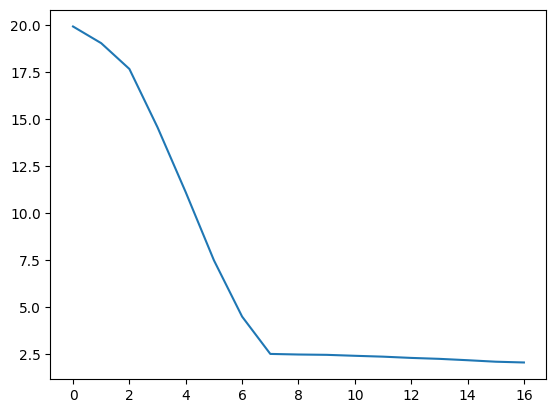

In [9]:
# For comparison, variational_inference with KNN method

opt_res = variational_inference(
    score, gauss_map,
    prior_param=prior_param,
    temperature=.1,
    per_step=160,
    VI_method='KNN',
    k = None,
    parallel=False, print_rec=20, chain_length=600,
    vectorized=True,
    momentum=.99, eta=0.1, silent=True)

end_distr = gauss_map(opt_res.opti_param)

print(f"Mean score of estimated posterior: {end_distr.integrate(score, n_sample = 1000)}")

# The evolution of the VI score can also be tracked:
plt.plot(opt_res.hist_score)

### Iter prior procedure

The iterated prior procedure is not a Bayesian technique at all. It is actually an optimisation routine, using a Bayesian flavored technique.

The goal is minimizing $S(x)$, a score function. In order to do that, parameters are drawn from a distribution. The distribution for the next generation is then obtained by centering around the best parameter found so far, and by using the top parameters found so far to construct the covariance. Each dimension of the parameter is drawn independantly from a gaussian distribution, so that the covariance is diagonal and can be defined by using the empirical standard deviations of the top parameters.

In [10]:
# The initial prior_param is a parameter for the TensorizedGaussianMap.
ini_prior = np.zeros((2,2))
ini_prior[1] = 1.0

opt_res = iter_prior(score, ini_prior_param = ini_prior, gen_per_step=800, chain_length=50, keep=100, frac_sparse=0.0, parallel=False)

# The opti_param attribute of opt_res gives a distribution and NOT a parameter
opti_distr_param = opt_res.opti_param

# The optimal parameter can still be found:
opti_param = opt_res.full_sample[0]
print(opti_param)

Step 50/50 (mean score: 0.000000)[1. 1.]


/Users/apicard/Documents/Suez/Git/ADUncertaintyQuantification/aduq/proba/gauss/TGauss/t_gaussian.py:59: RuntimeWarning: divide by zero encountered in log
  renorm_const = -0.5 * n_dim * np.log(2 * np.pi) - np.sum(np.log(devs))


The technique used in iter prior can still be useful in the context of variational inference, in order to construct quickly a good initial distribution. The function iter_prior_vi is designed precisely for that purpose.

In [11]:
opt_res = iter_prior_vi(
    score,
    prior_param = ini_prior, temperature=0.1, gen_per_step=800, chain_length=50, keep=100, frac_sparse=0.0,
    parallel=False, vectorized=True)

# The opti_param attribute of opt_res gives a distribution and NOT a parameter
opti_distr_param = opt_res.opti_param

start_post = np.zeros((3,2))

start_post[0] = opti_distr_param[0]
start_post[1:] = np.diag(opti_distr_param[1])

opt_res = variational_inference(
    score, gauss_map,
    prior_param=prior_param,
    post_param=start_post,
    temperature=.1,
    per_step=160,
    VI_method='corr_weights',
    gen_decay=np.log(1.2),
    k = 160 * 20,
    parallel=False,
    vectorized=True,
    print_rec=2, chain_length=50,
    refuse_conf=.95,
    momentum=.95, eta=0.1, silent=False)


Step 6/50 (mean score: 0.071048, kl : 5.673290))Converged (mean: 0.01661396305886843, kl: 7.258043522482131)
Score at step 0: 0.7393764912873002 (KL: 7.258043522482131, score:0.013572139039087047)
Score at step 2: 0.6014210746974326 (KL: 5.431137632653493, score:0.05830731143208322)
Score at step 4: 0.5836153040950263 (KL: 4.277470068407086, score:0.15586829725431767)
Score at step 6: 0.5391156154312543 (KL: 3.982377484953501, score:0.14087786693590423)
Score at step 8: 0.5098696568433029 (KL: 4.4205700491821736, score:0.0678126519250855)
Score at step 10: 0.5145651908430938 (KL: 4.1245452105715374, score:0.10211066978594005)
Score at step 12: 0.5143768822727779 (KL: 4.168755365780943, score:0.09750134569468355)
Score at step 14: 0.5106525792634591 (KL: 4.25650973714937, score:0.08500160554852199)
Score at step 16: 0.5147862148388223 (KL: 4.336246267127947, score:0.08116158812602746)
Score at step 18: 0.5189245617977724 (KL: 4.360747987674458, score:0.08284976303032651)
Score at step 2

/Users/apicard/Documents/Suez/Git/ADUncertaintyQuantification/aduq/bayes/variational_inference.py:696: ProbBadGrad: 
            Harmful step removed.
            (Previous score: 0.5098696568433029, new_score: 0.5345910355031747, UQ: 0.006046109374939362))
  warnings.warn(


Score at step 22: 0.5139274086901919 (KL: 4.187791680077824, score:0.09514824068240954)
Score at step 24: 0.5105467304148749 (KL: 4.095883923919201, score:0.10095833802295473)
Score at step 26: 0.5140470743548489 (KL: 4.067788327714832, score:0.10726824158336568)
Score at step 28: 0.5140043400344997 (KL: 4.095862318690292, score:0.1044181081654704)
Score at step 30: 0.5125998190267874 (KL: 4.1240843824160525, score:0.1001913807851821)
Score at step 32: 0.5124968584587829 (KL: 4.0950083729819475, score:0.10299602116058815)
Score at step 34: 0.5108759389929612 (KL: 4.04594346354624, score:0.10628159263833727)
Score at step 36: 0.5094255334649943 (KL: 4.043846225276884, score:0.10504091093730598)
Score at step 38: 0.5152944683981271 (KL: 4.071922410259701, score:0.108102227372157)
Score at step 40: 0.5166910978174122 (KL: 4.097355582716524, score:0.1069555395457597)
Score at step 42: 0.515643066202812 (KL: 4.102053890662211, score:0.1054376771365908)
Score at step 44: 0.5114099629174601 (

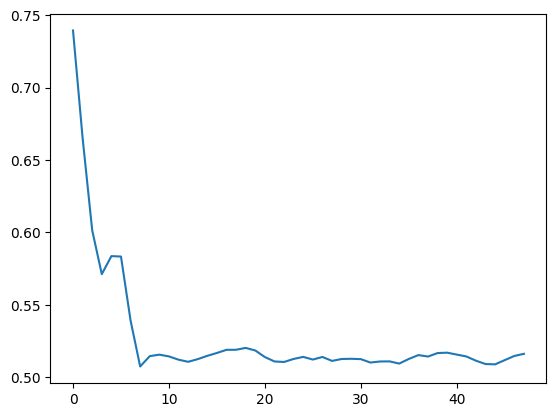

In [12]:
plt.plot(opt_res.hist_score)

## Uniform priors - Gaussian computations

The proba module offers a class of distributions on the hypercube benefitting from Gaussian like interpretation when the distribution are sufficiently concentrated and exact computations for KL.

In [13]:
from aduq.proba.gauss import GaussHypercubeMap

dim = 2

# Toy score function
def score(x):
    return (x @ np.array([1.0, 0.0], dtype=np.float64) - .6) ** 2 + 20 * (x @ np.array([1.0, -1.0], dtype=np.float64)) **2

pmap = GaussHypercubeMap(2)

In [14]:
opt_res = variational_inference(
    score, pmap,
    temperature=.1, # the lambda term in the variational inference problem
    per_step=160,
    VI_method='corr_weights',
    gen_decay=np.log(1.3),
    k = 160 * 30,
    parallel=False,
    vectorized=True,
    print_rec=10,
    chain_length=201,
    refuse_conf=.95,
    momentum=.95, eta=0.4, silent=False)

Score at step 0: 3.61549367517035 (KL: 0.0, score:3.61549367517035)
Score at step 10: 0.3141726465075083 (KL: 1.4463537157392283, score:0.1695372749335855)


/Users/apicard/Documents/Suez/Git/ADUncertaintyQuantification/aduq/bayes/variational_inference.py:696: ProbBadGrad: 
            Harmful step removed.
            (Previous score: 0.3384234641170658, new_score: 0.3881103571102223, UQ: 0.027540188632570663))
  warnings.warn(
/Users/apicard/Documents/Suez/Git/ADUncertaintyQuantification/aduq/bayes/variational_inference.py:696: ProbBadGrad: 
            Harmful step removed.
            (Previous score: 0.3160637108736127, new_score: 0.512514688037736, UQ: 0.005858342368155183))
  warnings.warn(


Score at step 20: 0.30500448139983716 (KL: 2.0542045474640056, score:0.09958402665343656)
Score at step 30: 0.2990337721508626 (KL: 1.4740972075155139, score:0.15162405139931115)
Score at step 40: 0.2930232254874265 (KL: 1.8808848172527823, score:0.10493474376214823)
Score at step 50: 0.2899135886973818 (KL: 1.7064034269402124, score:0.11927324600336059)
Score at step 60: 0.28679288873565856 (KL: 1.6386952015972869, score:0.12292336857592984)
Score at step 70: 0.28232423568130954 (KL: 1.8896917651582472, score:0.09335505916548481)
Score at step 80: 0.28226247286477457 (KL: 1.5242710984814292, score:0.12983536301663168)
Score at step 90: 0.284465359466498 (KL: 2.0431432110786143, score:0.08015103835863657)
Score at step 100: 0.2789370144446174 (KL: 1.7110599446727077, score:0.10783101997734656)
Score at step 110: 0.28299919958374053 (KL: 2.09674556541427, score:0.07332464304231354)
Score at step 120: 0.27887936436289334 (KL: 1.8429737052994029, score:0.09458199383295306)
Score at step 1

The posterior can adapt to scores with strong identifiability issues such as Rosenbrock, since the probabilities can exhibit strong correlation structure

([], [])

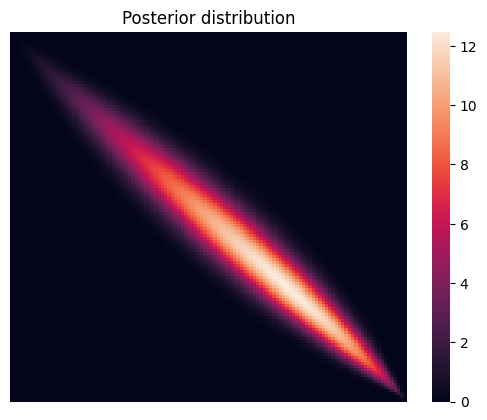

In [15]:
import seaborn as sns
proba = pmap(opt_res.opti_param)
# The log density of the function can be accessed through log_dens
x_axis_labels = np.linspace(10**-4,1 - 10** -4, 121)
y_axis_labels = np.linspace(10**-4,1- 10 ** -4, 121)

values = np.array(np.meshgrid(y_axis_labels, x_axis_labels)).T
z = proba.dens(values)

sns.heatmap(z, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.title("Posterior distribution")
plt.xticks([])
plt.yticks([])

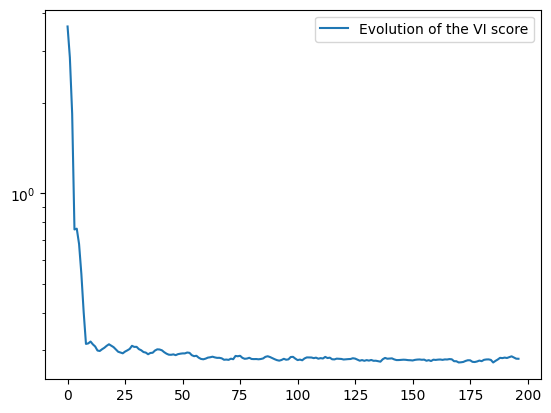

In [16]:
plt.plot(opt_res.hist_score, label="Evolution of the VI score")
plt.yscale("log")
plt.legend()
plt.show()